In [86]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
import warnings

warnings.filterwarnings("ignore")  # Ignore warnings for clearer output

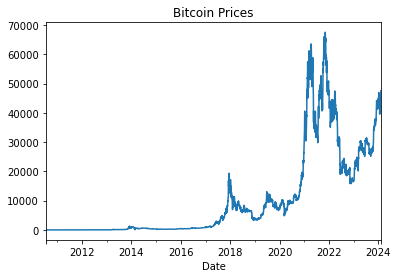

In [3]:
# Load the data
data = pd.read_csv('cleaned_data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Plot the data
data['Price'].plot(title='Bitcoin Prices')
plt.show()

In [4]:
from statsmodels.tsa.stattools import adfuller

# Function to perform the Dickey-Fuller test
def test_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(label + ' : ' + str(value))
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis (H0), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

# Check stationarity
test_stationarity(data['Price'])

ADF Test Statistic : -0.8947799966921307
p-value : 0.789686578663928
#Lags Used : 32
Number of Observations Used : 4922
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [5]:
# Fit auto ARIMA
model = auto_arima(data['Price'], seasonal=True, trace=True, error_action='ignore', suppress_warnings=True)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=78335.018, Time=1.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=78364.179, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=78360.416, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=78360.499, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=78363.232, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=78362.061, Time=0.52 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=78362.761, Time=0.79 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=78336.448, Time=2.70 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=78336.478, Time=1.76 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=78362.368, Time=0.24 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=78359.598, Time=0.71 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=78360.317, Time=0.75 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=78338.130, Time=1.88 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=78334.081, Time=0.95 sec
 ARIMA(1,1,2)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4955
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -39162.041
Date:                Fri, 26 Apr 2024   AIC                          78334.081
Time:                        09:17:38   BIC                          78366.621
Sample:                    07-18-2010   HQIC                         78345.491
                         - 02-09-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8212      0.007    124.262      0.000       0.808       0.834
ar.L2         -0.9487      0.006   -152.031      0.000      -0.961      -0.937
ma.L1         -0.8487      0.006   -135.527      0.000      -0.861      -0.836
ma.L2          0.9604      0.006    164.552      0.000       0.949       0.972
sigma2      4.333e+05   2503.287    173.075      0.000    4.28e+05    4.38e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.47   Jarque-Bera (JB):            116973.60
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):            1994.79   Skew:                            -0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [7]:
# Best model
best_order = model.order
model_arima = ARIMA(data['Price'], order=best_order)
fitted_model = model_arima.fit()

# Summary of the model
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 4955
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -39162.041
Date:                Fri, 26 Apr 2024   AIC                          78334.081
Time:                        09:17:44   BIC                          78366.621
Sample:                    07-18-2010   HQIC                         78345.491
                         - 02-09-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8212      0.007    124.262      0.000       0.808       0.834
ar.L2         -0.9487      0.006   -152.031      0.000      -0.961      -0.937
ma.L1         -0.8487      0.006   -135.527      0.0

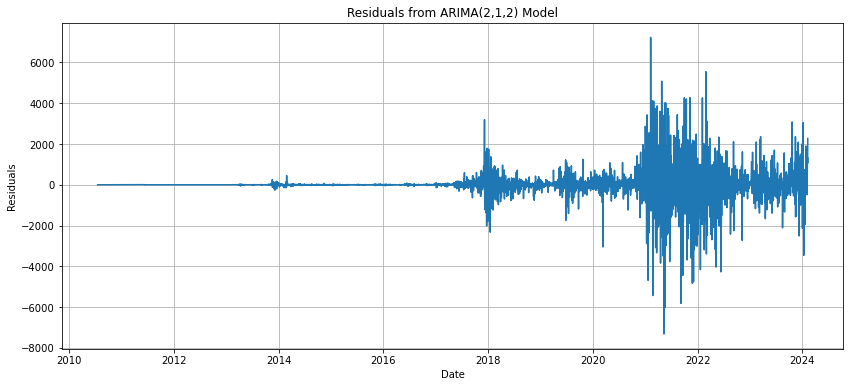

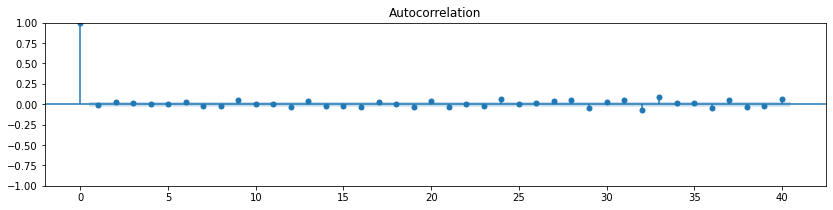

,lb_stat,lb_pvalue
10,27.524405,0.00215


In [8]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Plot the residuals from the ARIMA(2,1,2) model
residuals_212 = fitted_model.resid

plt.figure(figsize=(14, 6))
plt.plot(residuals_212)
plt.title('Residuals from ARIMA(2,1,2) Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

# ACF plot of the residuals to check for any autocorrelation
fig, ax = plt.subplots(figsize=(14, 3))
plot_acf(residuals_212, lags=40, ax=ax)
plt.show()


# Perform a statistical test on the residuals
ljung_box_result_212 = acorr_ljungbox(residuals_212, lags=[10], return_df=True)
ljung_box_result_212

In [71]:
# Load your data
data_path = 'cleaned_data.csv'
bitcoin_data = pd.read_csv(data_path)
bitcoin_data['Date'] = pd.to_datetime(bitcoin_data['Date'])
bitcoin_data.set_index('Date', inplace=True)
bitcoin_prices = bitcoin_data['Price']

# # Fit the ARIMA(2,1,2) model
# model = ARIMA(bitcoin_prices, order=(2,1,2))
# model_fit = model.fit()

# # Determine the last date in your data and set the forecast period for March
# last_date = bitcoin_prices.index[-1]
# forecast_start = pd.date_range(start=last_date, periods=2, freq='M')[0] + pd.DateOffset(days=1)
# forecast_end = pd.Timestamp(year=2024, month=3, day=31)





# Assume you have already loaded and prepared your data
# Assume you have already fitted your ARIMA model
model_fit = ARIMA(bitcoin_prices, order=(5,1,2)).fit()

# Define the start and end of the forecast period
forecast_start = '2024-02-15'  # Start of March 2024
forecast_end = '2024-09-30'    # End of March 2024

# Use get_prediction for date ranges
forecast_result = model_fit.get_prediction(start=forecast_start, end=forecast_end)
forecasted_prices = forecast_result.predicted_mean

# Print forecasted prices
print(forecasted_prices)






2024-02-15    47824.968410
2024-02-16    47833.392013
2024-02-17    47839.598913
2024-02-18    47842.178833
2024-02-19    47843.928802
                  ...     
2024-09-26    47845.899203
2024-09-27    47845.899203
2024-09-28    47845.899203
2024-09-29    47845.899203
2024-09-30    47845.899203
Freq: D, Name: predicted_mean, Length: 229, dtype: float64


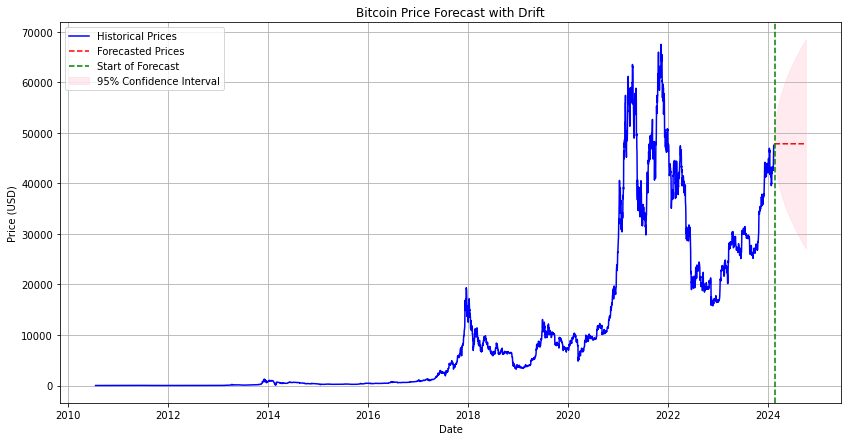

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# # Load your data
# data_path = 'cleaned_data.csv'
# bitcoin_data = pd.read_csv(data_path)
# bitcoin_data['Date'] = pd.to_datetime(bitcoin_data['Date'])
# bitcoin_data.set_index('Date', inplace=True)
# bitcoin_prices = bitcoin_data['Price']

# # Fit the ARIMA(2,1,2) model
# model = ARIMA(bitcoin_prices, order=(2,2,2))
# model_fit = model.fit()
# print(model_fit)
# Define the start and end of the forecast period for May
forecast_start = pd.Timestamp(forecast_start)
forecast_end = pd.Timestamp(forecast_end)

# Use get_prediction for date ranges, with dynamic forecast to incorporate drift
forecast_result = model_fit.get_prediction(start=forecast_start, end=forecast_end, dynamic=True)
forecasted_prices = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()  # Confidence intervals for the forecast

# Plot historical data
plt.figure(figsize=(14, 7))
plt.plot(bitcoin_prices, label='Historical Prices', color='blue')

# Plot forecasted data
forecast_dates = pd.date_range(start=forecast_start, end=forecast_end, freq='D')
plt.plot(forecast_dates, forecasted_prices, label='Forecasted Prices', color='red', linestyle='--')

# Highlight the forecast start
plt.axvline(x=forecast_start, color='green', linestyle='--', label='Start of Forecast')

# Add drift explanation and confidence intervals
plt.fill_between(forecast_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')

plt.title('Bitcoin Price Forecast with Drift')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


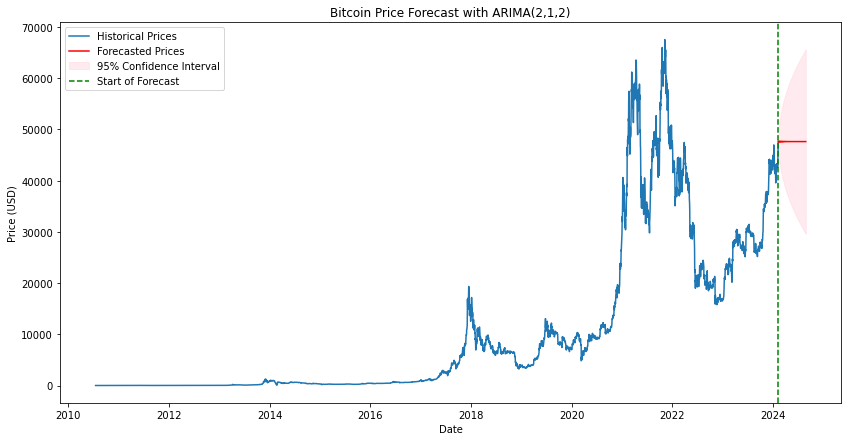

In [95]:


# Assume bitcoin_prices is a pandas Series with the Bitcoin price data
# Make sure to have the actual historical Bitcoin prices in the Series

# # Fit the ARIMA(2,1,2) model
# model = ARIMA(bitcoin_prices, order=(2, 1, 2))
# model_fit = model.fit()

# Forecast the next 200 periods
forecast = model_fit.get_forecast(steps=200)
forecast_index = pd.date_range(start=bitcoin_prices.index[-1], periods=201, freq='D')[1:]
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Plotting the historical data
plt.figure(figsize=(14, 7))
plt.plot(bitcoin_prices.index, bitcoin_prices, label='Historical Prices')

# Plotting the forecasted mean
plt.plot(forecast_index, forecast_mean, label='Forecasted Prices', color='red')

# Plotting the confidence intervals
plt.fill_between(forecast_index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')

# Highlight the start of the forecast
plt.axvline(x=bitcoin_prices.index[-1], linestyle='--', color='green', label='Start of Forecast')

plt.title('Bitcoin Price Forecast with ARIMA(2,1,2)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# # Simulating historical data for demonstration (replace this with actual data)
# np.random.seed(0)
# n_periods = 2000
# historical_data = pd.Series(np.random.normal(0, 1, n_periods).cumsum())


# Simulate fitting an ARIMA(2,1,2) model (in practice, use your fitted model)
# Replace with: model = ARIMA(historical_data, order=(2,1,2))
# Replace with: model_fit = model.fit()
model = ARIMA(bitcoin_data, order=(2,1,2))
model_fit = model.fit()

# Forecasting 200 periods ahead
forecast_result = model_fit.get_forecast(steps=200)

# Get the forecast and the confidence intervals
forecasted_values = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(historical_data, color='black', label='Historical Data')

# Plot the forecasted values
plt.plot(np.arange(len(historical_data), len(historical_data) + 200), forecasted_values, color='blue', linestyle='--', label='Forecasted Data')

# Plot the confidence intervals
plt.fill_between(np.arange(len(historical_data), len(historical_data) + 200), conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='grey', alpha=0.5, label='95% Confidence Interval')

plt.title('Forecasts from ARIMA(2,1,2) with 200 periods')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


ValueError: SARIMAX models require univariate `endog`. Got shape (4955, 6).

Missing values in each column:
 Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64


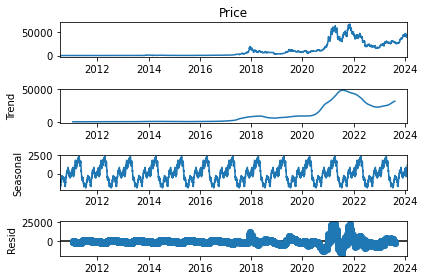

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.49451D+00    |proj g|=  3.68729D-02


 This problem is unconstrained.



At iterate    5    f=  7.48806D+00    |proj g|=  4.38230D-04

At iterate   10    f=  7.48791D+00    |proj g|=  3.37594D-03


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load your data
data = pd.read_csv('cleaned_data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Check for missing values
print("Missing values in each column:\n", data.isnull().sum())

# Seasonal Decompose to check for seasonality
decomposition = seasonal_decompose(data['Price'], model='additive', period=365)
fig = decomposition.plot()
plt.show()

# Fit a SARIMA model
model = SARIMAX(data['Price'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 365))
results = model.fit()

# Summary of the model
print(results.summary())

# Diagnostics plots
results.plot_diagnostics(figsize=(15, 12))
plt.show()

# Check ACF and PACF for residual autocorrelation
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
plot_acf(results.resid, lags=40, ax=axes[0])
plot_pacf(results.resid, lags=40, ax=axes[1])
plt.show()

# Optionally, predict future points
preds = results.get_forecast(steps=30)
preds_ci = preds.conf_int()
plt.figure(figsize=(10, 5))
plt.plot(data['Price'], label='observed')
plt.plot(preds.predicted_mean, label='Forecast', color='r')
plt.fill_between(preds_ci.index, preds_ci.iloc[:, 0], preds_ci.iloc[:, 1], color='pink')
plt.legend()
plt.show()

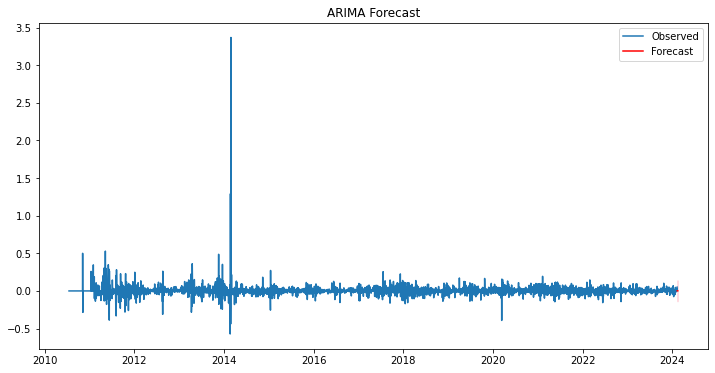

In [30]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Load the data from a CSV file
df = pd.read_csv('cleaned_data.csv')

# Assume the data frame has two columns: 'Date' and 'Value'
# Convert the 'Date' column to datetime and set it as the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Assume 'Value' is the column with the data we want to forecast
time_series = df['Change %']

# Fit an ARIMA model to the time series
# The order (p,d,q) needs to be determined by analysis (e.g., ACF, PACF plots)
# Here we're using placeholder values for the ARIMA(p,d,q) model
p, d, q = 1, 1, 1  # Placeholder values
model = ARIMA(time_series, order=(p, d, q))
model_fit = model.fit()

# Forecast the next N steps (N being a placeholder for the number of steps you want to forecast)
N = 5
forecast = model_fit.get_forecast(steps=N)
forecast_index = pd.date_range(start=time_series.index[-1], periods=N + 1, closed='right')
forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)

# Construct the confidence intervals for the forecasts
confidence_intervals = forecast.conf_int()

# Plot the time series and forecasts with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(time_series, label='Observed')
plt.plot(forecast_series, label='Forecast', color='red')

# Plot the confidence intervals
plt.fill_between(forecast_index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1],
                 color='pink', alpha=0.5)

plt.title('ARIMA Forecast')
plt.legend()
plt.show()


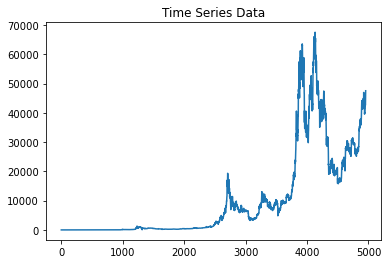

ADF Statistic: -0.8947799966921307
p-value: 0.789686578663928


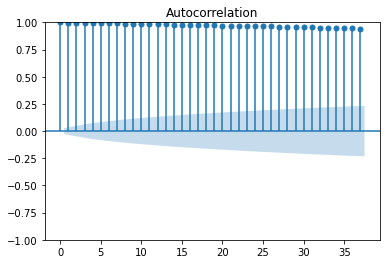

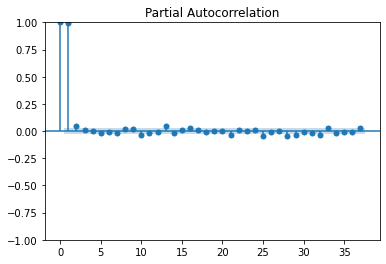

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=78364.179, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=78360.499, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=78362.169, Time=0.26 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=78360.872, Time=0.36 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=78357.555, Time=0.52 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=78359.099, Time=0.64 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=78360.416, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=78362.368, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=78362.061, Time=0.51 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=78359.598, Time=0.73 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=78359.158, Time=1.21 sec
 ARIMA(1,1,5)(0,0,0)[1] intercept   : AIC=78361.073, Time=0.74 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=78362.265, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=78362.761, Time=0.70 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=78335.018, Time=1.44

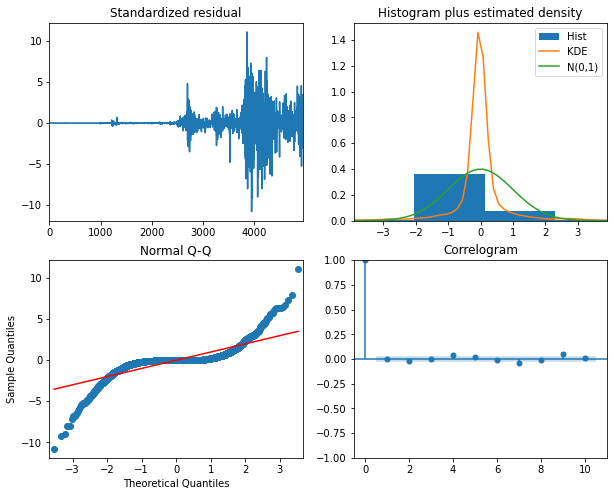

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

# Step 1: Load the data
df = pd.read_csv('cleaned_data.csv')
ts = df['Price']  # Replace with your actual time series column name

# Step 2: Visualize the data
plt.plot(ts)
plt.title('Time Series Data')
plt.show()

# Step 3: Stationarity test
result = adfuller(ts)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Make the series stationary if necessary (differecing if p-value > 0.05)

# Step 4: Identify p and q using ACF and PACF
plot_acf(ts)
plot_pacf(ts)
plt.show()

# Step 5: Model selection using auto_arima (from the pmdarima package)
best_model = auto_arima(ts, seasonal=True, stepwise=False, suppress_warnings=True, 
                        error_action="ignore", max_order= None, trace=True)

print(best_model.summary())

# Step 6: Model diagnostics
best_model.plot_diagnostics(figsize=(10,8))
plt.show()




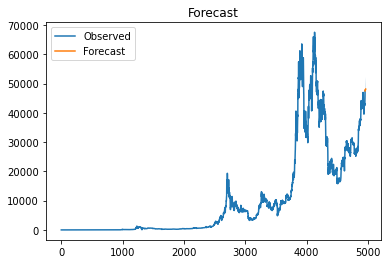

In [70]:
# Step 7: Forecasting
n_periods = 10
forecast, conf_int = best_model.predict(n_periods=n_periods, return_conf_int=True)

# Plot the forecast alongside the original series
plt.plot(ts.index, ts, label='Observed')
plt.plot(np.arange(len(ts), len(ts) + n_periods), forecast, label='Forecast')
plt.fill_between(np.arange(len(ts), len(ts) + n_periods), conf_int[:, 0], conf_int[:, 1], alpha=0.3)
plt.title('Forecast')
plt.legend()
plt.show()